# Gaussian Mixture

Se trata de un modelo no supervisado que permite generar clustering pero analizando la probabilidad de pertenecer a cada Segmento.

![](board.PNG)

![](gmm.PNG)

# Hiperparámetros : covariance_type

![](cov_shapes.PNG)

# Implementación en Python 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import set_config
set_config(display = 'diagram')

In [2]:
df = pd.read_csv('iris.csv')
df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
X = df.drop(columns = 'class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state = 123)

# Gaussian Mixture 

## Visualización con PCA

El siguiente gráfico muestra la separación de Clases en Iris mediante una reducción de dimensionalidad usando PCA.

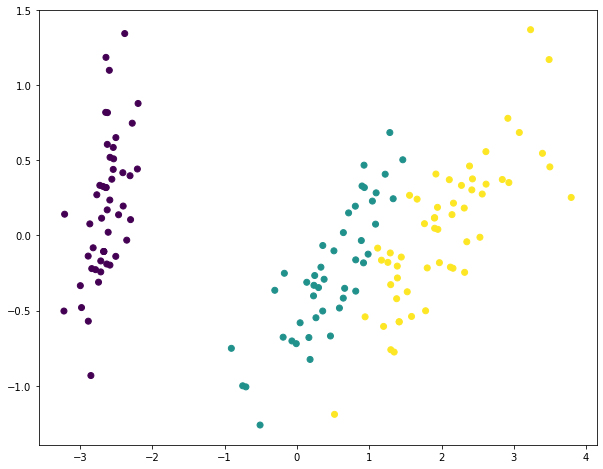

In [5]:
pca = PCA(n_components = 2, random_state = 123)
data = pca.fit_transform(X)
plt.figure(figsize = (10,8))
plt.scatter(data[:,0], data[:,1], c = y_labels)
plt.show()

## Separación de Clases por GMM

El siguiente ejemplo muestra el resultado de Clusterización realizado por GMM sin nunca habr mostrado las clases correctas.

In [4]:
gmm = GaussianMixture(n_components = 3, random_state = 123)
y_labels = gmm.fit_predict(X)
y_proba = gmm.predict_proba(X)

pd.Series(y_labels).value_counts()

2    55
0    50
1    45
dtype: int64

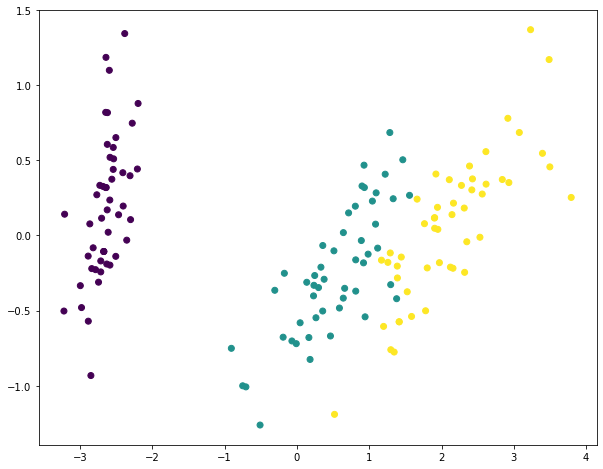

In [6]:
colors = y.astype('category').cat.codes
plt.figure(figsize = (10,8))
plt.scatter(data[:,0], data[:,1], c = colors)
plt.show()

> NOTA: Este es un problema no supervisado, en ningún momento se le dan las clases para saber cuál es el resultado que debería dar.

# Titanic

Se busca probar la calidad GMM intentando encontrar una segmentación que permite identificar la clase de cada pasajero utilizando algunas variables demógraficas de los pasajeros. En ningún momento se le mostrará al algoritmo la clase real de cada pasajero.

In [7]:
titanic = pd.read_csv('titanic.csv', index_col = 'PassengerId')
titanic

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Signing_date
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1911-05-17
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1911-07-23
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1911-09-08
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1911-06-26
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1911-10-25
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1911-08-17
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1911-08-07
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1912-01-30


In [8]:
df = titanic[['Sex','Age','Fare','Embarked']].copy()
df[['Sex','Embarked']] = df[['Sex','Embarked']].astype('category')

In [9]:
is_cat = df.dtypes == 'category'
is_cat

Sex          True
Age         False
Fare        False
Embarked     True
dtype: bool

## Implementación del modelo mediante Pipelines 

In [10]:
cat = Pipeline(steps = [
    ('cat_imp', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder())
])

num = Pipeline(steps = [
    ('num_imp', SimpleImputer(strategy = 'mean')),
    ('sc', StandardScaler())
])

preprocessing = ColumnTransformer(transformers = [
    ('cat', cat, is_cat),
    ('num', num, ~is_cat)
])

pipe = Pipeline(steps = [
    ('prep', preprocessing), 
    ('gmm', GaussianMixture(n_components = 3, random_state = 123))
])

y_labels = pipe.fit_predict(df)

# Separación de clases vista con PCA.

En este ejemplo se ve la separación real de las clases existentes. Esta visualización es posible mediante una reducción de dimensionalidad realizada mediante PCA.

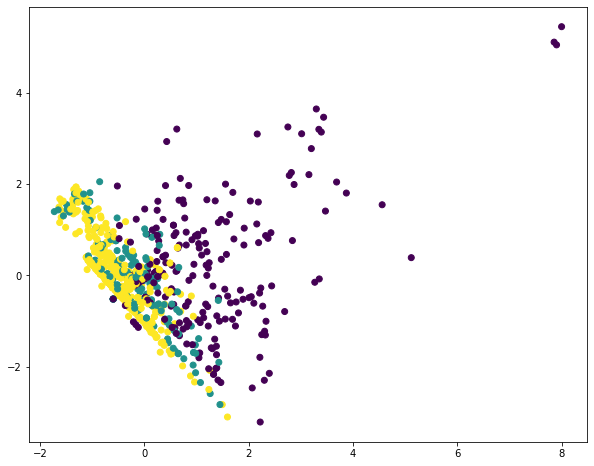

In [11]:
pipe2 = Pipeline(steps = [
    ('prep', preprocessing), 
    ('pca', PCA(n_components = 2, random_state = 123))
]) 

data = pipe2.fit_transform(df)

plt.figure(figsize = (10,8))
plt.scatter(data[:,0], data[:,1], c = titanic.Pclass)
plt.show()

## Visualización resultados mediante GMM

A continuación se muestran los resultados de la predicción realizada por GMM en la que jamás se mostraron las clases  verdaderas. Si bien no son perfectas es capaz de generar una buena predicción para una de las clases (presumiblemente la primera, que posee mayor diferencia con el resto) y tiende a confundir la segunda y tercera (las cuales tienen una menor diferencia entre ellas). 

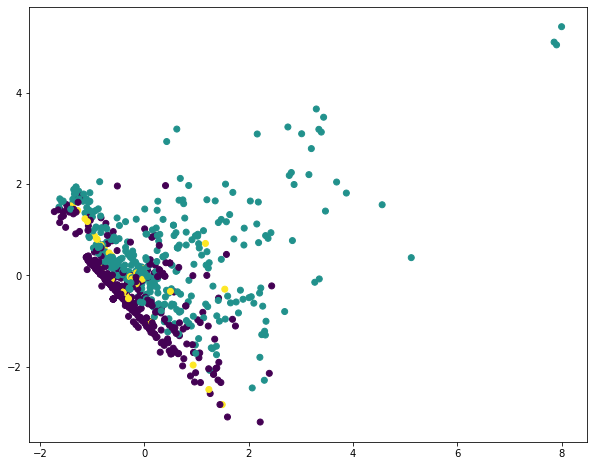

In [12]:
plt.figure(figsize = (10,8))
plt.scatter(data[:,0], data[:,1], c = y_labels)
plt.show()

In [13]:
accuracy_score(titanic.Pclass, y_labels) # no es válido medir el accuracy ya que el nombre de cada clase no es compatible

0.16049382716049382

## Ventajas del GMM

GMM es un algoritmo de clustering que permite además devolver la probabilidad de pertenecer a un cierto cluster.

In [14]:
y_proba = pipe.predict_proba(df)
pd.DataFrame(y_proba)

,0,1,2
0,1.0,1.002966e-08,0.0
1,0.0,1.000000e+00,0.0
2,0.0,1.000000e+00,0.0
3,0.0,1.000000e+00,0.0
4,1.0,1.058396e-08,0.0
...,...,...,...
886,1.0,9.200172e-09,0.0
887,0.0,1.000000e+00,0.0
888,0.0,1.000000e+00,0.0
889,0.0,1.000000e+00,0.0


In [15]:
df = pd.DataFrame(np.argsort(y_proba), columns = ['third','second','first'])
df

,third,second,first
0,2,1,0
1,0,2,1
2,0,2,1
3,0,2,1
4,2,1,0
...,...,...,...
886,2,1,0
887,0,2,1
888,0,2,1
889,0,2,1


# LDA: Latent Dirichlet Allocation

Este es un pequeño ejemplo de cómo combinar un modelo LDA para encontrar tópicos combinando arquitectura de Pipeline, preprocesamiento de un Bag of Words básico y extracción de tópicos.

> NOTA: Esto fue realizado a modo demostrativo sobre una muestra muy pequeña por lo tanto los resultados no son representativos.

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
df = pd.read_csv('letras_sample.csv')

In [22]:
%%time
pipe = Pipeline(steps = [
    ('cv', CountVectorizer(stop_words = 'english')),
    ('lda', LatentDirichletAllocation(n_components = 10, n_jobs = -1))
])

pipe.fit(df.lyrics)

words = pipe.named_steps.cv.get_feature_names()

topics = pipe.named_steps.lda.components_

Topics_ordered = pd.DataFrame(topics, columns = words).T

def call_top_topics(topics_df, topic_n, top_n):
    return topics_df[topic_n].sort_values().head(top_n)

call_top_topics(Topics_ordered, 0, 10)